In [1]:
from Tetris_env import *
import torch 
from torch import nn
from torch import optim
import copy
from collections import deque
import collections 
import random
from tqdm.notebook import tqdm
import math

import matplotlib.pyplot as plt 

pygame 2.5.1 (SDL 2.28.2, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Agent neural network is implemented down here

In [2]:
class Simple_net(nn.Module):
    def __init__(self, img_hight, img_weidth, num_channels, num_actions, kernel_sizes, device) :
        super().__init__()
        self.img_hight = img_hight
        self.img_weidth = img_weidth
        self.num_actions = num_actions
        self.conv1 = nn.Conv2d(num_channels, 3, kernel_size=kernel_sizes[0], padding=int((kernel_sizes[0]-1)/2))
        self.conv2 = nn.Conv2d(3, 1, kernel_size=kernel_sizes[1], padding=int((kernel_sizes[1]-1)/2))
        self.relu = nn.ReLU()
        self.target_lin = nn.Linear(((img_hight)*(img_weidth)*1), num_actions)
        self.device = device
        self.to(device)

    def forward(self,x):
        x = x.permute((0,3,2,1))
        h = self.conv1(x)
        h = self.relu(self.conv2(x))
        B, W, H, C = h.shape
        h = h.view((B, W*H*C))
        return self.target_lin(h)
    
    @torch.no_grad()
    def predict(self, x):
        self.eval()
        q_values = self.forward(x)
        return q_values


In [3]:
class clip_based(nn.Module):
    def __init__(self, img_hight, img_weidth, num_channels, num_actions, kernel_sizes, device) :
        super().__init__()
        self.img_hight = img_hight
        self.img_weidth = img_weidth
        self.num_actions = num_actions
        self.conv1 = nn.Conv2d(num_channels, 3, kernel_size=kernel_sizes[0], padding=int((kernel_sizes[0]-1)/2))
        self.conv2 = nn.Conv2d(3, 3, kernel_size=kernel_sizes[1], padding=int((kernel_sizes[1]-1)/2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.lin1 = nn.Linear(((img_hight)*(img_weidth)*3), 1024)
        self.target_embeding = nn.Embedding(self.num_actions, 512)
        self.target_lin = nn.Linear(512, 1024)
        self.device = device
        self.to(device)

    def forward(self,x):
        x = x.permute((0,3,2,1))
        h = self.conv1(x)
        h = self.relu(self.conv2(x))
        B, W, H, C = h.shape
        h = self.tanh(self.lin1(h.view((B, W*H*C)))) # <B,1024>
        t = torch.tensor([i for i in range(self.num_actions)], device=self.device)
        t = self.tanh(self.target_embeding(t))
        t = self.target_lin(t) 
        out = torch.einsum("ij, kj->ik", h, t)
        return out
    
    @torch.no_grad()
    def predict(self, x):
        self.eval()
        q_values = self.forward(x)
        return q_values

#### Defining priority replay buffer class

In [4]:
class Priority_replay_buffer():
    def __init__(self, buffer_size, batch_size, alpha):
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.alpha = alpha 
        self.replay_buffer = deque(maxlen=buffer_size)
        self.priority_buffer = deque(maxlen=buffer_size)

    def add(self, observations):
        state, action, next_state, reward, done = observations
        self.replay_buffer.append((state, action, next_state, reward, done)) # <state, action, next_state, reward, done>
        self.priority_buffer.append(max(self.priority_buffer, default=1))

    def get_priorities(self):
        scaled = np.array(self.priority_buffer)**self.alpha
        priority = scaled/scaled.sum()
        return priority

    def sample(self, beta):
        priorities = self.get_priorities()
        sample_indices = random.choices(range(len(self.replay_buffer)), k=self.batch_size, weights=priorities)
        batch = [self.replay_buffer[i] for i in sample_indices]
        weights = ((1/self.buffer_size)*priorities)**(-1*beta)
        weights = weights[sample_indices] / weights[sample_indices].max()
        return list(map(list, zip(*batch))), weights, sample_indices
    
    def update_priorities(self, priorities, indices):
        for idx, value in zip(list(indices), list(priorities)):
            self.priority_buffer[idx] = value

### Agent itself is implemented down here as well

In [5]:
class Agent():
    def __init__(self,
                img_hight ,
                img_weidth ,
                kernel_sizes,
                actions_to_id,
                id_to_actions,
                num_channels=3,
                num_actions = 5,
                alpha = 0.5,
                start_beta = 0.1, 
                gamma = 0.99, 
                lr = 3e-3,
                batch_size = 256, 
                buffer_size = 1000, # best one was 1000
                min_replay_size = 300,
                epsilon_start = 1 ,
                epsilon_end = 0.01,
                epsilon_decay = 0.009,
                target_update_freq = 1000,
                optimizer = torch.optim.AdamW,
                loss_module = nn.MSELoss,
                device = torch.device("cpu"),
                double = False):
        
        #Model parameters initialization 
        self.img_hight = img_hight
        self.img_weidth = img_weidth
        self.kernel_sizes = kernel_sizes
        self.num_channels = num_channels
        self.num_actions = num_actions
        

        self.action_to_id = actions_to_id
        self.id_to_action = id_to_actions
        # learning parameters initialization 
        self.alpha = alpha
        self.beta_increase = 1.04
        self.beta = start_beta
        self.double = double
        self.gamma = gamma
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.min_replay_size = min_replay_size
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.device = device
        self.iters = 0


        self.replay_buffer = Priority_replay_buffer(self.buffer_size, self.batch_size, self.alpha)
        self.online_network = clip_based(self.img_hight, self.img_weidth, self.num_channels, self.num_actions, self.kernel_sizes, self.device)
        self.target_network = clip_based(self.img_hight, self.img_weidth, self.num_channels, self.num_actions, self.kernel_sizes, self.device)
        self.target_network.load_state_dict(self.online_network.state_dict())

        self.optimizer = optimizer(self.online_network.parameters(), lr=lr)
        self.loss_module = loss_module(reduction='none')


    '''
        This function updates beta term for training bias of prioritized replay buffer
    '''
    def update_beta(self):
        self.beta = self.beta*self.beta_increase
        if self.beta > 1:
            self.beta = 1

    '''
        This function stores a set of <state, action, next_state, reward, done> in replay buffer 
    '''
    def buffer_transition(self, state, action, next_state, reward, done):
        self.replay_buffer.add((state, action, next_state, reward, done))


    '''
        This function is used for action selection based on given state and epsilon in currect iteration 
    '''
    def select_action(self, state, epsilon):
        state = state.unsqueeze(0)
        if torch.rand(1) < epsilon:
            return self.id_to_action[torch.randint(0, self.num_actions,(1,)).item()]
        else:
            q_values = self.online_network.predict(state)
            return self.id_to_action[torch.argmax(q_values.to("cpu")).unsqueeze(0).detach().item()]
    
    
    '''
        Thi function is used for initializing the buffer of the agent for the first time so the agent can be trained on something
    '''
    def initialize_replay_buffer(self, env):
        state = env.reset()
        for _ in range(self.min_replay_size):
            action = self.id_to_action[torch.randint(0, self.num_actions,(1,)).item()]
            next_state, reward, done, _, _ = env.step(action)
            self.buffer_transition(state, self.action_to_id[action], next_state, reward, done)
            state = next_state
            if done : 
                state = env.reset()
        env.reset()


    '''
        This function calculate the loss for prioritizing replay buffer 
    '''
    def calculate_abs_loss(self, state, action, next_state, reward, done):
        q_values = self.online_network.predict(state)
        action_q_values = torch.gather(input=q_values, dim=1, index=action)
        if self.double:
            next_online_q_values = self.online_network.predict(next_state)
            next_online_action_values = next_online_q_values.argmax(dim=1, keepdim=True)

            target_q_values = self.target_network.predict(next_state)
            target_action_q_value = torch.gather(input=target_q_values, dim=1, index=next_online_action_values)
            target = reward + self.gamma*(1-done)*target_action_q_value
        else : 
            target_q_values = self.target_network.predict(next_state)
            terget_action_q_value = target_q_values.max(dim=1, keepdim=True)[0]
            target = reward + self.gamma*(1-done)*terget_action_q_value
            
        loss = torch.abs(action_q_values - target)
        return loss
    
    
    '''
        This function calculates the error incase of our need 
    '''
    def calculate_error(self, state, action, next_state, reward, done):
        if self.double:
            next_online_q_values = self.online_network.predict(next_state)
            next_online_action_values = next_online_q_values.argmax(dim=1, keepdim=True)

            target_q_values = self.target_network.predict(next_state)
            target_action_q_value = torch.gather(input=target_q_values, dim=1, index=next_online_action_values)
            target = reward + self.gamma*(1-done)*target_action_q_value
        else : 
            target_q_values = self.target_network.predict(next_state)
            terget_action_q_value = target_q_values.max(dim=1, keepdim=True)[0]
            target = reward + self.gamma*(1-done)*terget_action_q_value
        self.online_network.train()
        q_values = self.online_network(state)
        action_q_values = torch.gather(input=q_values, dim=1, index=action)
        loss = self.loss_module(action_q_values, target)
        return loss


    '''
        This function updates the target network in the specified time interval 
    '''
    def update_target_network(self):
        if self.iters % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.online_network.state_dict())


    '''
        This function updates the online network based given batch of <state, action, next_state, reward, done>
        and
        Updates the target network with specific frequency 
    '''
    def update_online_network(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.iters+=1 
        self.update_target_network()
        return loss.item()

    def learn(self):
        transitions, weights, indices = self.replay_buffer.sample(self.beta)
        self.update_beta()
        #I have first converted the list to numpy array and then converted them to torch tensor because it has shown to be faster 
        state = np.asarray(transitions[0])
        action = np.asarray(transitions[1])
        next_state = np.asarray(transitions[2])
        reward = np.asarray(transitions[3])
        done = np.asarray(transitions[4])

        state = torch.as_tensor(state, dtype=torch.float32).to(self.device)
        action = torch.as_tensor(action, dtype=torch.int64).to(self.device).unsqueeze(-1)
        next_state = torch.as_tensor(next_state, dtype=torch.float32).to(self.device)
        reward = torch.as_tensor(reward, dtype=torch.float32).to(self.device).unsqueeze(-1)
        done = torch.as_tensor(done, dtype=torch.float32).to(self.device).unsqueeze(-1)

        #In this part I only updated the online network by applying normal weighted learning 
        loss = self.calculate_error(state, action, next_state, reward, done)
        loss = torch.mean(loss * torch.as_tensor(weights, device=self.device))
        loss = self.update_online_network(loss)

        #And now its time to update priorities of each samples in our batch in replay buffer 
        deltas = self.calculate_abs_loss(state, action, next_state, reward, done)
        priorities = (deltas.cpu()
                            .detach()
                            .numpy()
                            .flatten())
        self.replay_buffer.update_priorities(priorities + 1e-6, indices)
        return loss

### Training of the agent is implemented down below 

In [6]:
def training(env, agent, num_episods, reward_inc=1, rbsd=False, max_num_iters=100):
    episod_rewards = []
    episods_loss = []
    eps = agent.epsilon_start
    epsilon_trace = []
    reward_threshold = -1e7
    agent.initialize_replay_buffer(env)
    

    pbar = tqdm(range(num_episods))
    for episod in pbar:
        episod_reward = 0
        episod_loss = 0 
        done = False
        state = env.reset()
        if eps == agent.epsilon_end:
            print("Epsilon is at the end point")

        for iter in range(max_num_iters) :
            action = agent.select_action(torch.tensor(state,dtype=torch.float32, device=agent.device) , eps)
            next_state, reward, done, _, _ = env.step(action)

            agent.buffer_transition(state, agent.action_to_id[action], next_state, reward, done)

            state = next_state
            if rbsd : 
                if reward >= reward_threshold:
                    eps = eps - agent.epsilon_decay if eps > agent.epsilon_end else agent.epsilon_end
                    epsilon_trace.append(eps)
                    reward_threshold = reward + reward_inc
            else :
                eps = eps - agent.epsilon_decay if eps > agent.epsilon_end else agent.epsilon_end
                epsilon_trace.append(eps)


            episod_reward += reward
            loss = agent.learn()
            episod_loss += loss

            if done or iter==max_num_iters:
                state = env.reset()
                break

        episod_rewards.append(episod_reward)
        episods_loss.append(episod_loss)
        pbar.set_description(f"Episod <{episod+1}> the training loss is :[{episod_loss}]")
    

    env.close()
    return agent, episod_rewards, episods_loss, epsilon_trace

In [7]:
action_to_id = {
    "left": 0,
    "right": 1,
    "up": 2,
    "down": 3,
    "do nothing": 4
}
id_to_action = {
    0: "left",
    1: "right",
    2: "up",
    3: "down",
    4: "do nothing"
}

### These are hyper parameters that had to be defined 

In [8]:
img_hight = 300
img_weidth = 150
kernel_sizes = [3,9]
num_channels = 3
num_actions = 5
start_beta = 0.2
alpha = 0.7
gamma = 0.85 #0.8 was not really good || 0.85 was good || 0.88 not good || 0.88 <0.83 < 0.85
lr = 1e-4 # 1e-4
num_episods = 170
batch_size = 512
buffer_size = 10000 # best one was 1000
min_replay_size = 1000
target_update_freq = 512
optimizer = torch.optim.Adam
loss_module = nn.MSELoss
double = False
max_iters = 90
epsilon_start = 1
epsilon_end = 0.01
epsilon_decay = (epsilon_start - epsilon_end)/(max_iters*num_episods)
epsilon_decay

6.470588235294117e-05

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
env = Tetris_environment()


In [11]:
agent = Agent(
    img_hight,
    img_weidth,
    kernel_sizes,
    action_to_id,
    id_to_action,
    num_channels,
    num_actions,
    alpha,
    start_beta,
    gamma,
    lr,
    batch_size,
     buffer_size,
    min_replay_size,
    epsilon_start,
    epsilon_end,
    epsilon_decay,
    target_update_freq,
    optimizer,
    loss_module,
    device,
    double
)

In [12]:
agent, episod_rewards, episods_loss, epsilon_trace = training(env, agent, num_episods, rbsd=False, max_num_iters=max_iters) 

  0%|          | 0/170 [00:00<?, ?it/s]

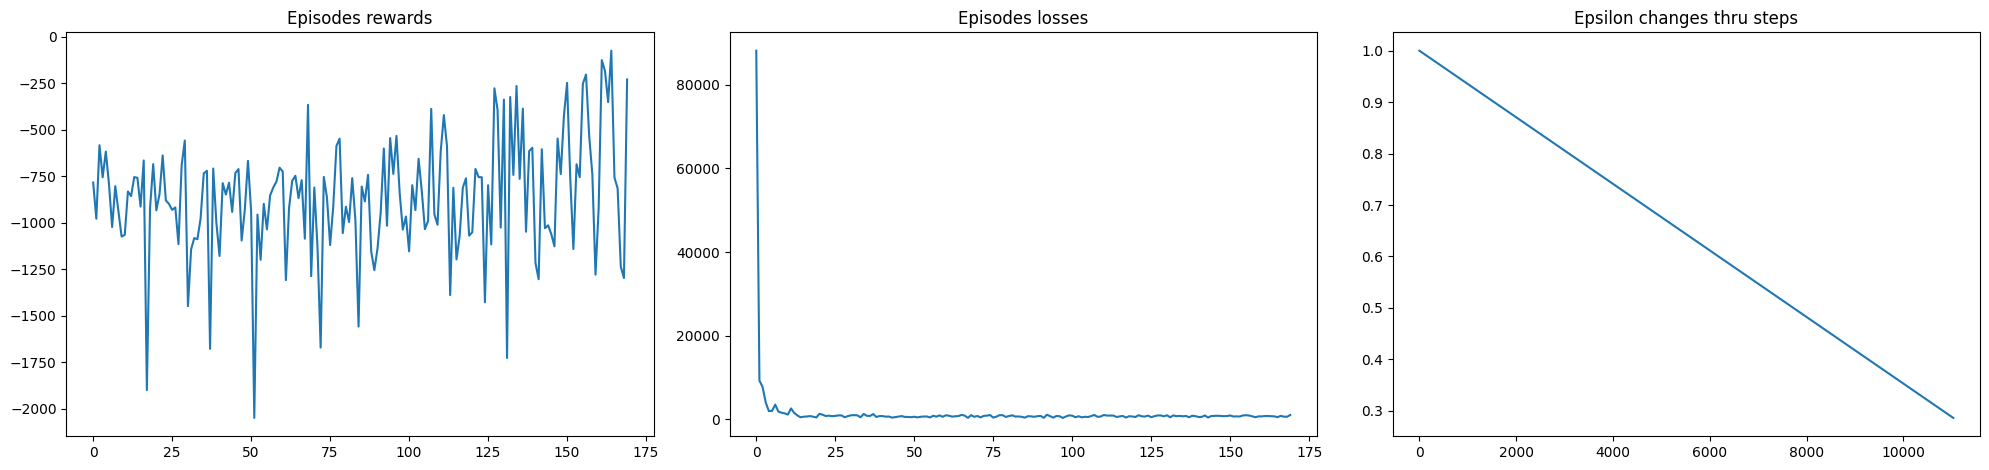

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(20)
axs[0].plot(episod_rewards)
axs[0].set_title("Episodes rewards")

axs[1].plot(episods_loss)
axs[1].set_title("Episodes losses")

axs[2].plot(epsilon_trace)
axs[2].set_title("Epsilon changes thru steps")
plt.tight_layout()
plt.show()

In [14]:
env.close()

In [19]:
# torch.save(agent.online_network.state_dict(), "online_net.pth")

In [16]:
@torch.no_grad()
def play(agent, env):
    done=False
    agent.online_network.eval()
    rewards = 0

    state = env.reset()
    while not done:
        action = agent.select_action(torch.tensor(state,dtype=torch.float32, device=agent.device) , 0)

        next_state, reward, done, _, _ = env.step(action)
        state = next_state
        rewards += reward
    env.close()
    print(rewards)
    return rewards

In [17]:
reward = play(agent, env)

-1676.6070100471002
